# loading data and prepprocessing


In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense , Dropout

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path='/content/drive/My Drive/diagnosis.csv'

diagnosis=pd.read_csv(path)

In [ ]:
diagnosis['diagnosis'] = diagnosis['diagnosis'].map({'M':1,'B':0})

y= diagnosis.diagnosis
y.head()

0    1
1    1
2    1
3    1
4    1
Name: diagnosis, dtype: int64

In [ ]:
# Indicies of each class' observations
i_class0 = np.where(y == 0)[0]
i_class1 = np.where(y == 1)[0]

# Number of observations in each class
n_class0 = len(i_class0)
n_class1 = len(i_class1)

print(n_class0)
print(n_class1)

357
212


In [ ]:
drop_list=['Unnamed: 32','id','diagnosis']
x=diagnosis.drop(drop_list, axis=1)
x.dtypes
x.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
x = (x - x.mean()) / (x.std()) 
x.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,2.215566,2.253764,2.487545,-0.564768,2.830540,2.485391,-0.213814,1.315704,0.723390,0.660239,1.147747,0.906286,1.885031,-1.358098,2.301575,1.999478,1.306537,2.614365,2.107672,2.294058,2.748204,1.935312
1,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,0.001391,-0.867889,0.498816,-0.875473,0.263095,0.741749,-0.604819,-0.692317,-0.440393,0.259933,-0.804742,-0.099356,1.804340,-0.368879,1.533776,1.888827,-0.375282,-0.430066,-0.146620,1.086129,-0.243675,0.280943
2,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,0.938859,-0.397658,1.227596,-0.779398,0.850180,1.180298,-0.296744,0.814257,0.212889,1.423575,0.236827,0.293301,1.510541,-0.023953,1.346291,1.455004,0.526944,1.081980,0.854222,1.953282,1.151242,0.201214
3,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,2.864862,4.906602,0.326087,-0.110312,0.286341,-0.288125,0.689095,2.741868,0.818798,1.114027,4.728520,2.045711,-0.281217,0.133866,-0.249720,-0.549538,3.391291,3.889975,1.987839,2.173873,6.040726,4.930672
4,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,-0.009552,-0.561956,1.269426,-0.789549,1.272070,1.189310,1.481763,-0.048477,0.827742,1.143199,-0.360775,0.498889,1.297434,-1.465481,1.337363,1.219651,0.220362,-0.313119,0.612640,0.728618,-0.867590,-0.396751


In [ ]:
diagnosis = pd.concat([y,x], axis = 1)
diagnosis.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,2.215566,2.253764,2.487545,-0.564768,2.830540,2.485391,-0.213814,1.315704,0.723390,0.660239,1.147747,0.906286,1.885031,-1.358098,2.301575,1.999478,1.306537,2.614365,2.107672,2.294058,2.748204,1.935312
1,1,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,0.001391,-0.867889,0.498816,-0.875473,0.263095,0.741749,-0.604819,-0.692317,-0.440393,0.259933,-0.804742,-0.099356,1.804340,-0.368879,1.533776,1.888827,-0.375282,-0.430066,-0.146620,1.086129,-0.243675,0.280943
2,1,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,0.938859,-0.397658,1.227596,-0.779398,0.850180,1.180298,-0.296744,0.814257,0.212889,1.423575,0.236827,0.293301,1.510541,-0.023953,1.346291,1.455004,0.526944,1.081980,0.854222,1.953282,1.151242,0.201214
3,1,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,2.864862,4.906602,0.326087,-0.110312,0.286341,-0.288125,0.689095,2.741868,0.818798,1.114027,4.728520,2.045711,-0.281217,0.133866,-0.249720,-0.549538,3.391291,3.889975,1.987839,2.173873,6.040726,4.930672
4,1,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,-0.009552,-0.561956,1.269426,-0.789549,1.272070,1.189310,1.481763,-0.048477,0.827742,1.143199,-0.360775,0.498889,1.297434,-1.465481,1.337363,1.219651,0.220362,-0.313119,0.612640,0.728618,-0.867590,-0.396751


In [ ]:
#Split training and test sets 

from sklearn.model_selection import train_test_split 
#Split 70% train 30% test 
X_train,X_test,y_train,y_test = train_test_split(x.values, y.values, test_size=0.3 , random_state = 0)

X_train.shape
X_test.shape
y_train.shape
y_test.shape


(171,)

# Upsampling

In [ ]:
from sklearn.utils import resample

# concatenate our training data back together
data_concat = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)

# separate minority and majority classes
y_B_0= data_concat[data_concat.iloc[:, -1] == 0]
y_M_1= data_concat[data_concat.iloc[:, -1] == 1]

# upsample minority
y_M_1_upsampled = resample(y_M_1,
                          replace=True, # sample with replacement
                          n_samples=len(y_B_0), # match number in majority class
                          random_state=345) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([pd.DataFrame(y_B_0), pd.DataFrame(y_M_1_upsampled )])

# check new class counts
upsampled.iloc[:, -1].value_counts()

y_train = upsampled.iloc[:, -1].values
X_train = upsampled.iloc[:, :-1].values

# Training different models 

In [ ]:
#SVM linear 
from sklearn.svm import SVC
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV

model_svm = SVC(kernel = "rbf", C=10, gamma= 0.01)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()


In [ ]:
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier()

In [ ]:
from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB()

In [ ]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression()

In [ ]:
from sklearn.model_selection import KFold

def stacking_model (model, X_train, y_train, X_test, n_folds):
    kfold = KFold(n_splits = n_folds, random_state = 0)

    train_fold_predict = np.zeros((X_train.shape[0], 1))
    test_predict = np.zeros((X_test.shape[0], n_folds))
    print("model : ", model.__class__.__name__)

    for i, (train_index, valid_index) in enumerate(kfold.split(X_train)):
        X_train_new = X_train[train_index]
        y_train_new = y_train[train_index]
        X_val = X_train[valid_index]

        model.fit(X_train_new, y_train_new)

        train_fold_predict[valid_index, :] = model.predict(X_val).reshape(-1, 1)

        test_predict[:, i] = model.predict(X_test)
    
    test_predict_mean = np.mean(test_predict, axis = 1).reshape(-1, 1)

    return train_fold_predict, test_predict_mean

dt_train, dt_test = stacking_model(model_dt, X_train, y_train, X_test, 5)
lr_train, lr_test = stacking_model(model_lr,  X_train, y_train, X_test, 5)
svm_train, svm_test = stacking_model(model_svm,  X_train, y_train, X_test, 5)
nb_train, nb_test = stacking_model(model_nb,  X_train, y_train, X_test, 5)
rf_train, rf_test = stacking_model(model_rf, X_train, y_train, X_test, 5)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will ra

model :  DecisionTreeClassifier
model :  LogisticRegression
model :  SVC
model :  GaussianNB
model :  RandomForestClassifier


# (SVM+LR+NB+DT)+ANN


In [ ]:
# SVM/LR/NB/DT

new_X_train = np.concatenate((svm_train, lr_train,  nb_train, dt_train), axis = 1)
new_X_test = np.concatenate((svm_test, lr_test, nb_test, dt_test), axis = 1)

print(X_train.shape, X_test.shape)
print(new_X_train.shape, new_X_test.shape)


(498, 30) (171, 30)
(498, 4) (171, 4)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense , Dropout


classifier = Sequential() # Initialising the ANN

classifier.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu', input_dim = 4))
classifier.add(Dropout(0.1))
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.1))
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.1))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

## Compiling ANN
classifier.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

## Fitting the data
model_history=classifier.fit(new_X_train, y_train, batch_size = 40, epochs = 1200, validation_split=0.2)


Train on 398 samples, validate on 100 samples
Epoch 1/1200
398/398 [==============================] - 0s 521us/step - loss: 0.6923 - accuracy: 0.6256 - val_loss: 0.7000 - val_accuracy: 0.0000e+00
Epoch 2/1200
398/398 [==============================] - 0s 50us/step - loss: 0.6909 - accuracy: 0.6256 - val_loss: 0.7050 - val_accuracy: 0.0000e+00
Epoch 3/1200
398/398 [==============================] - 0s 47us/step - loss: 0.6896 - accuracy: 0.6256 - val_loss: 0.7099 - val_accuracy: 0.0000e+00
Epoch 4/1200
398/398 [==============================] - 0s 50us/step - loss: 0.6884 - accuracy: 0.6256 - val_loss: 0.7142 - val_accuracy: 0.0000e+00
Epoch 5/1200
398/398 [==============================] - 0s 47us/step - loss: 0.6871 - accuracy: 0.6256 - val_loss: 0.7182 - val_accuracy: 0.0000e+00
Epoch 6/1200
398/398 [==============================] - 0s 47us/step - loss: 0.6855 - accuracy: 0.6256 - val_loss: 0.7209 - val_accuracy: 0.0000e+00
Epoch 7/1200
398/398 [==============================] - 0s 

In [ ]:
#ANN structure 
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 54        
_________________________________________________________________
dropout_3 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [ ]:
fin_predict = classifier.predict(new_X_test)
fin_predict = (fin_predict >= 0.5)
print(metrics.accuracy_score(y_true = y_test, y_pred=fin_predict))

0.9649122807017544


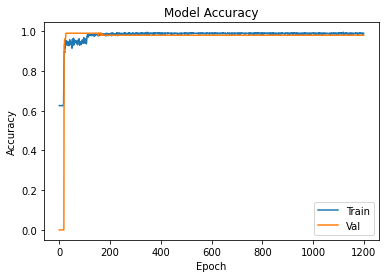

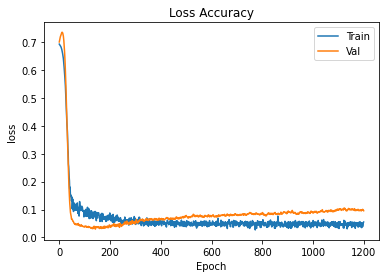

In [ ]:
# plot training & validation accuracy values

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()


# plot training & validation loss values

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss Accuracy')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [ ]:
#!pip install mlxtend

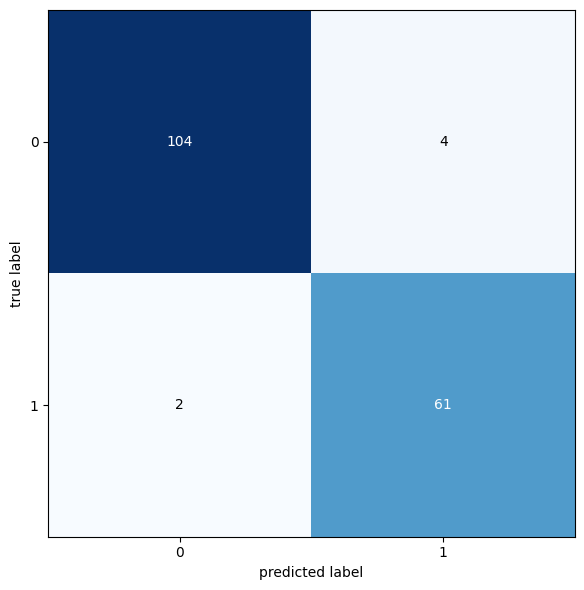

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
mat=confusion_matrix(y_test, fin_predict)
fig, ax=plot_confusion_matrix(conf_mat=mat, figsize=(6,6),show_normed=False)
plt.tight_layout()
fig.savefig('cm.png')

# (SVM + LR+ NB  + RF) + ANN 

In [ ]:
new_X_train_2 = np.concatenate((rf_train, lr_train, svm_train, nb_train), axis = 1)
new_X_test_2 = np.concatenate((rf_test, lr_test, svm_test, nb_test), axis = 1)
print(X_train.shape, X_test.shape)
print(new_X_train_2.shape, new_X_test_2.shape)

(498, 30) (171, 30)
(498, 4) (171, 4)


In [ ]:
model_history_2=classifier.fit(new_X_train_2, y_train, batch_size = 40, epochs = 1200, validation_split=0.2)

Train on 398 samples, validate on 100 samples
Epoch 1/1200
398/398 [==============================] - 0s 49us/step - loss: 0.3318 - accuracy: 0.9573 - val_loss: 0.2708 - val_accuracy: 0.9600
Epoch 2/1200
398/398 [==============================] - 0s 62us/step - loss: 0.3330 - accuracy: 0.9598 - val_loss: 0.2403 - val_accuracy: 0.9600
Epoch 3/1200
398/398 [==============================] - 0s 50us/step - loss: 0.2197 - accuracy: 0.9598 - val_loss: 0.2130 - val_accuracy: 0.9600
Epoch 4/1200
398/398 [==============================] - 0s 49us/step - loss: 0.2216 - accuracy: 0.9598 - val_loss: 0.1883 - val_accuracy: 0.9600
Epoch 5/1200
398/398 [==============================] - 0s 50us/step - loss: 0.2389 - accuracy: 0.9598 - val_loss: 0.1673 - val_accuracy: 0.9600
Epoch 6/1200
398/398 [==============================] - 0s 47us/step - loss: 0.1969 - accuracy: 0.9548 - val_loss: 0.1396 - val_accuracy: 0.9600
Epoch 7/1200
398/398 [==============================] - 0s 48us/step - loss: 0.2161 

In [ ]:
fin_predict_2 = classifier.predict(new_X_test_2)
fin_predict_2 = (fin_predict_2 >= 0.5)
print(metrics.accuracy_score(y_true = y_test, y_pred=fin_predict_2))

0.9649122807017544


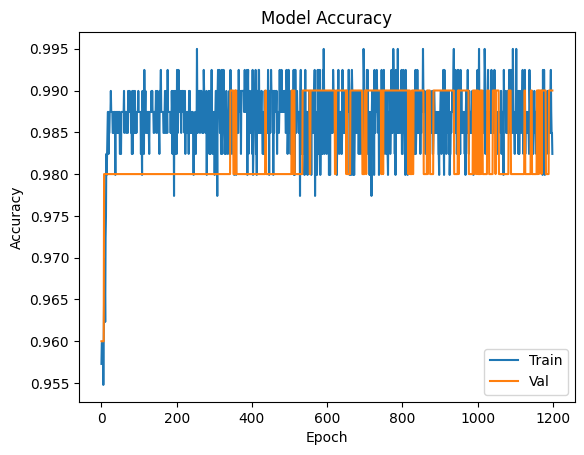

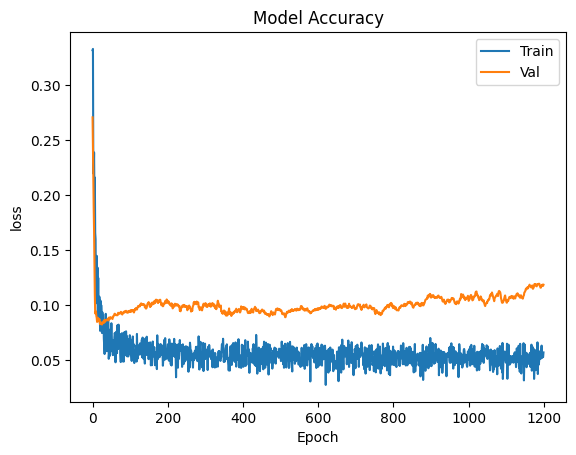

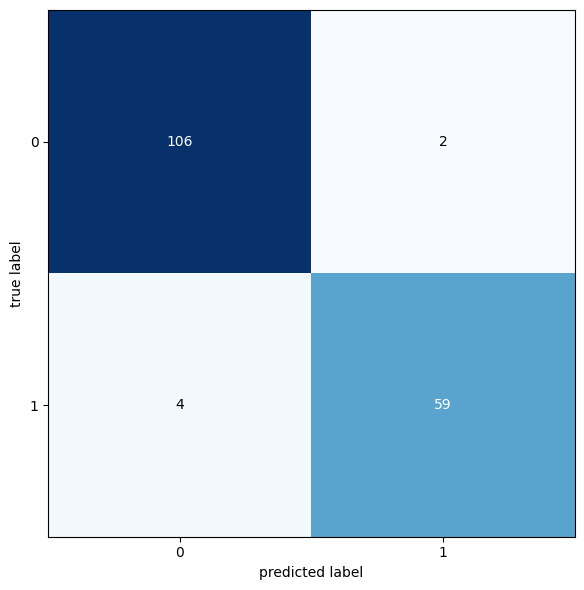

In [ ]:
#visualization of result


# plot training & validation accuracy values

plt.plot(model_history_2.history['accuracy'])
plt.plot(model_history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()


# plot training & validation loss values

plt.plot(model_history_2.history['loss'])
plt.plot(model_history_2.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


matplotlib.rcParams.update(matplotlib.rcParamsDefault)
mat=confusion_matrix(y_test, fin_predict_2)
fig, ax=plot_confusion_matrix(conf_mat=mat, figsize=(6,6),show_normed=False)
plt.tight_layout()
fig.savefig('cm.png')

# (SVM+LR+RF+DT)+ANN

In [ ]:
new_X_train_3 = np.concatenate((dt_train, lr_train, svm_train, rf_train), axis = 1)
new_X_test_3 = np.concatenate((dt_test, lr_test, svm_test, rf_test), axis = 1)

print(X_train.shape, X_test.shape)
print(new_X_train_3.shape, new_X_test_3.shape)

(498, 30) (171, 30)
(498, 4) (171, 4)


In [ ]:
model_history_3=classifier.fit(new_X_train_3, y_train, batch_size = 40, epochs = 1200, validation_split=0.2)

Train on 398 samples, validate on 100 samples
Epoch 1/1200
398/398 [==============================] - 0s 59us/step - loss: 0.1414 - accuracy: 0.9774 - val_loss: 0.2533 - val_accuracy: 0.9700
Epoch 2/1200
398/398 [==============================] - 0s 54us/step - loss: 0.1401 - accuracy: 0.9849 - val_loss: 0.2465 - val_accuracy: 0.9700
Epoch 3/1200
398/398 [==============================] - 0s 54us/step - loss: 0.1228 - accuracy: 0.9774 - val_loss: 0.2418 - val_accuracy: 0.9700
Epoch 4/1200
398/398 [==============================] - 0s 48us/step - loss: 0.1621 - accuracy: 0.9749 - val_loss: 0.2280 - val_accuracy: 0.9700
Epoch 5/1200
398/398 [==============================] - 0s 48us/step - loss: 0.1187 - accuracy: 0.9724 - val_loss: 0.2274 - val_accuracy: 0.9700
Epoch 6/1200
398/398 [==============================] - 0s 46us/step - loss: 0.1363 - accuracy: 0.9774 - val_loss: 0.2259 - val_accuracy: 0.9700
Epoch 7/1200
398/398 [==============================] - 0s 45us/step - loss: 0.1199 

In [ ]:
fin_predict_3 = classifier.predict(new_X_test_3)
fin_predict_3 = (fin_predict_3 >= 0.5)
print(metrics.accuracy_score(y_true = y_test, y_pred=fin_predict_3))

0.9532163742690059


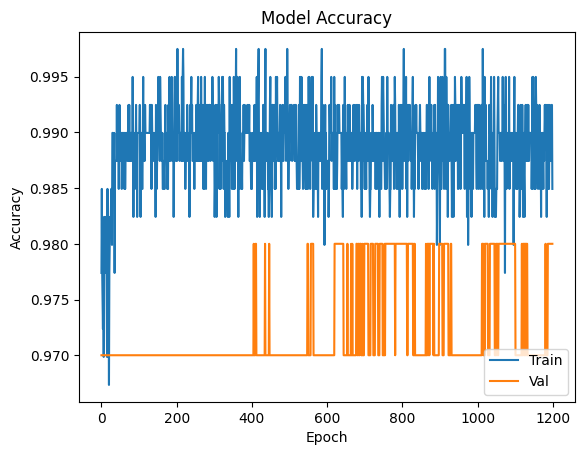

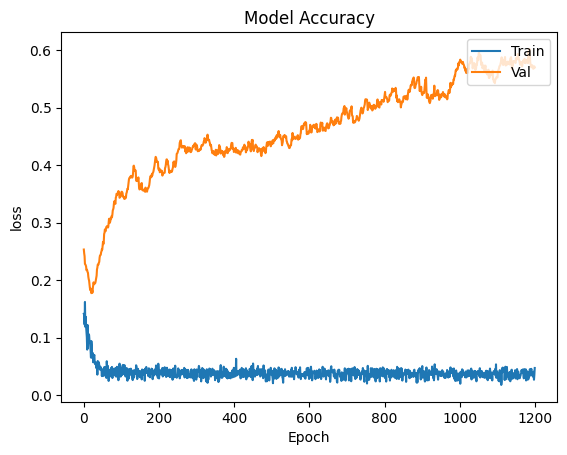

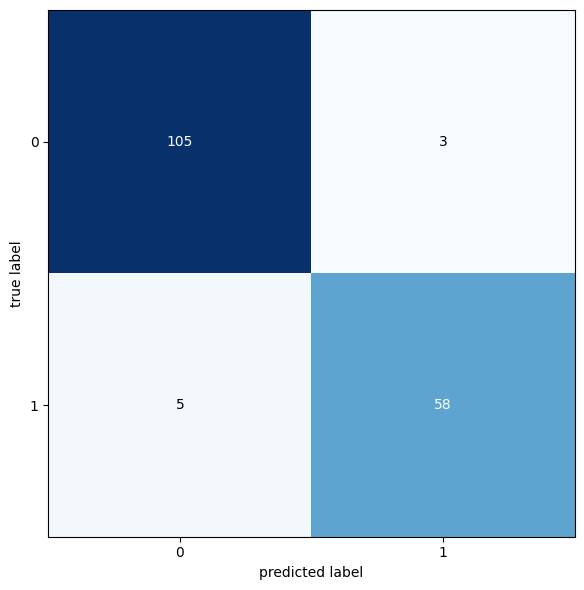

In [ ]:
#visualization of result


# plot training & validation accuracy values

plt.plot(model_history_3.history['accuracy'])
plt.plot(model_history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()


# plot training & validation loss values

plt.plot(model_history_3.history['loss'])
plt.plot(model_history_3.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


matplotlib.rcParams.update(matplotlib.rcParamsDefault)
mat=confusion_matrix(y_test, fin_predict_3)
fig, ax=plot_confusion_matrix(conf_mat=mat, figsize=(6,6),show_normed=False)
plt.tight_layout()
fig.savefig('cm.png')

# (SVM + LR + NB + RF + DT) + ANN

In [ ]:
new_X_train_4 = np.concatenate((nb_train,dt_train, lr_train, svm_train, rf_train), axis = 1)
new_X_test_4 = np.concatenate((nb_test,dt_test, lr_test, svm_test, rf_test), axis = 1)

print(X_train.shape, X_test.shape)
print(new_X_train_4.shape, new_X_test_4.shape)

(498, 30) (171, 30)
(498, 5) (171, 5)


In [ ]:
classifier_5 = Sequential() # Initialising the ANN

classifier_5.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu', input_dim = 5))
classifier_5.add(Dropout(0.1))
classifier_5.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
classifier_5.add(Dropout(0.1))
classifier_5.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
classifier_5.add(Dropout(0.1))
classifier_5.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

## Compiling ANN
classifier_5.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

model_history_4=classifier_5.fit(new_X_train_4, y_train, batch_size =40, epochs = 1200, validation_split=0.2)

Train on 398 samples, validate on 100 samples
Epoch 1/1200
398/398 [==============================] - 0s 429us/step - loss: 0.6922 - accuracy: 0.6457 - val_loss: 0.7000 - val_accuracy: 0.0000e+00
Epoch 2/1200
398/398 [==============================] - 0s 52us/step - loss: 0.6904 - accuracy: 0.6256 - val_loss: 0.7041 - val_accuracy: 0.0000e+00
Epoch 3/1200
398/398 [==============================] - 0s 49us/step - loss: 0.6880 - accuracy: 0.6256 - val_loss: 0.7065 - val_accuracy: 0.0000e+00
Epoch 4/1200
398/398 [==============================] - 0s 46us/step - loss: 0.6851 - accuracy: 0.6256 - val_loss: 0.7076 - val_accuracy: 0.0000e+00
Epoch 5/1200
398/398 [==============================] - 0s 45us/step - loss: 0.6814 - accuracy: 0.6256 - val_loss: 0.7063 - val_accuracy: 0.0000e+00
Epoch 6/1200
398/398 [==============================] - 0s 46us/step - loss: 0.6771 - accuracy: 0.6256 - val_loss: 0.7023 - val_accuracy: 0.0000e+00
Epoch 7/1200
398/398 [==============================] - 0s 

In [ ]:
fin_predict_4 = classifier_5.predict(new_X_test_4)
fin_predict_4 = (fin_predict_4 >= 0.5)
print(metrics.accuracy_score(y_true = y_test, y_pred=fin_predict_4))

0.9649122807017544


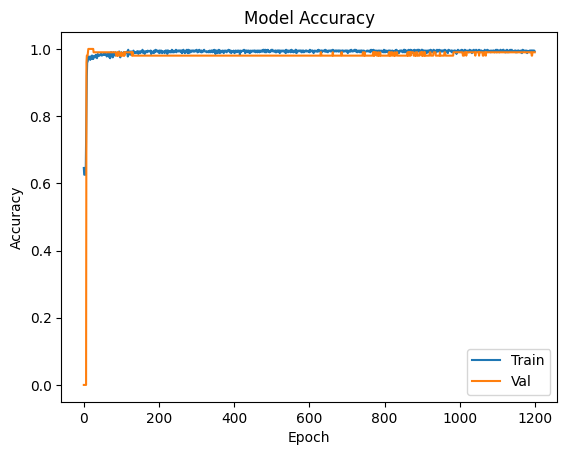

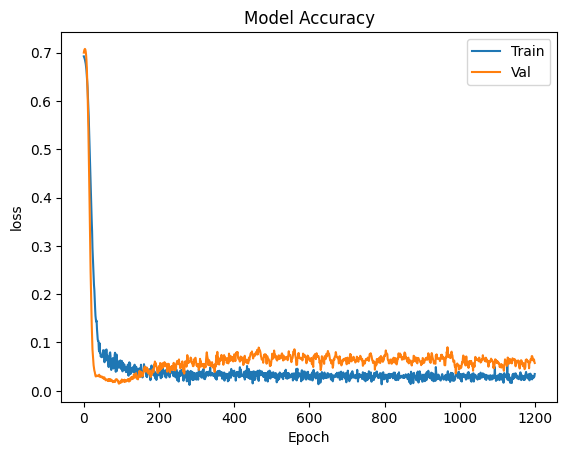

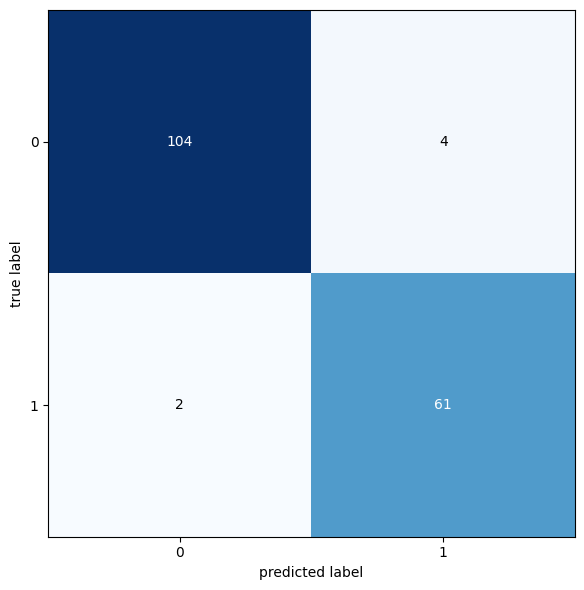

In [ ]:
#visualization of result


# plot training & validation accuracy values

plt.plot(model_history_4.history['accuracy'])
plt.plot(model_history_4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()


# plot training & validation loss values

plt.plot(model_history_4.history['loss'])
plt.plot(model_history_4.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


matplotlib.rcParams.update(matplotlib.rcParamsDefault)
mat=confusion_matrix(y_test, fin_predict_4)
fig, ax=plot_confusion_matrix(conf_mat=mat, figsize=(6,6),show_normed=False)
plt.tight_layout()
fig.savefig('cm.png')

# (SVM + LR + RF) + ANN

In [ ]:
new_X_train_5 = np.concatenate((lr_train, svm_train, rf_train), axis = 1)
new_X_test_5 = np.concatenate((lr_test, svm_test, rf_test), axis = 1)

print(X_train.shape, X_test.shape)
print(new_X_train_5.shape, new_X_test_5.shape)

(498, 30) (171, 30)
(498, 3) (171, 3)


In [ ]:
classifier_3 = Sequential() # Initialising the ANN

classifier_3.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu', input_dim = 3))
classifier_3.add(Dropout(0.1))
classifier_3.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
classifier_3.add(Dropout(0.1))
classifier_3.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
classifier_3.add(Dropout(0.1))
classifier_3.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

## Compiling ANN
classifier_3.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_history_5=classifier_3.fit(new_X_train_5, y_train, batch_size = 40, epochs = 1200, validation_split=0.2)

Train on 398 samples, validate on 100 samples
Epoch 1/1200
398/398 [==============================] - 0s 427us/step - loss: 0.6922 - accuracy: 0.6281 - val_loss: 0.7006 - val_accuracy: 0.0000e+00
Epoch 2/1200
398/398 [==============================] - 0s 47us/step - loss: 0.6907 - accuracy: 0.6256 - val_loss: 0.7057 - val_accuracy: 0.0000e+00
Epoch 3/1200
398/398 [==============================] - 0s 46us/step - loss: 0.6894 - accuracy: 0.6256 - val_loss: 0.7104 - val_accuracy: 0.0000e+00
Epoch 4/1200
398/398 [==============================] - 0s 50us/step - loss: 0.6878 - accuracy: 0.6256 - val_loss: 0.7151 - val_accuracy: 0.0000e+00
Epoch 5/1200
398/398 [==============================] - 0s 51us/step - loss: 0.6862 - accuracy: 0.6256 - val_loss: 0.7193 - val_accuracy: 0.0000e+00
Epoch 6/1200
398/398 [==============================] - 0s 50us/step - loss: 0.6844 - accuracy: 0.6256 - val_loss: 0.7230 - val_accuracy: 0.0000e+00
Epoch 7/1200
398/398 [==============================] - 0s 

In [ ]:
fin_predict_5 = classifier_3.predict(new_X_test_5)
fin_predict_5 = (fin_predict_5 >= 0.5)
print(metrics.accuracy_score(y_true = y_test, y_pred=fin_predict_5))

0.9649122807017544


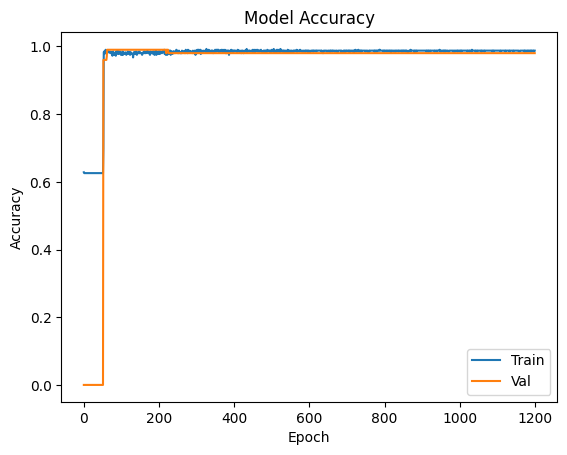

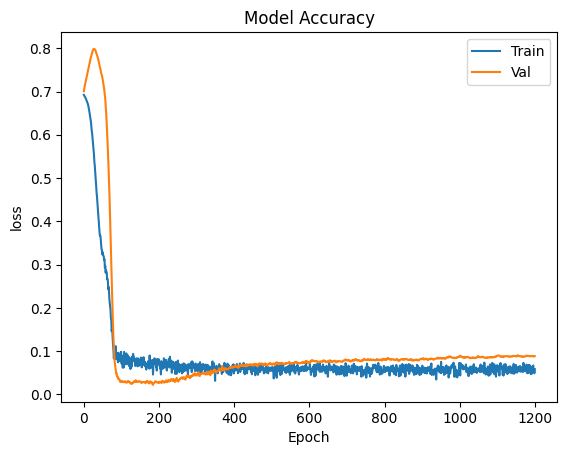

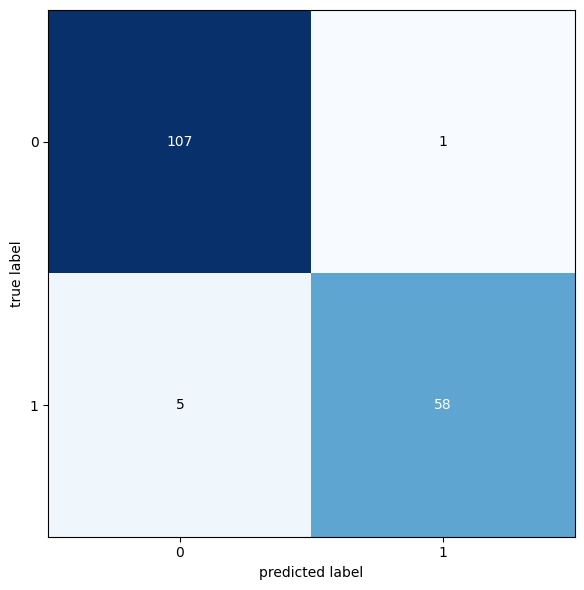

In [ ]:
#visualization of result


# plot training & validation accuracy values

plt.plot(model_history_5.history['accuracy'])
plt.plot(model_history_5.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()


# plot training & validation loss values

plt.plot(model_history_5.history['loss'])
plt.plot(model_history_5.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


matplotlib.rcParams.update(matplotlib.rcParamsDefault)
mat=confusion_matrix(y_test, fin_predict_5)
fig, ax=plot_confusion_matrix(conf_mat=mat, figsize=(6,6),show_normed=False)
plt.tight_layout()
fig.savefig('cm.png')

# (SVM+LR+RF+NB)+ANN

In [ ]:
new_X_train_6 = np.concatenate((lr_train, svm_train,rf_train,nb_train), axis = 1)
new_X_test_6 = np.concatenate((lr_test, svm_test,rf_test, nb_test), axis = 1)


print(X_train.shape, X_test.shape)
print(new_X_train_6.shape, new_X_test_6.shape)

(498, 30) (171, 30)
(498, 4) (171, 4)


In [ ]:
model_history_6=classifier.fit(new_X_train_6, y_train, batch_size = 40, epochs = 1200, validation_split=0.2)

Train on 398 samples, validate on 100 samples
Epoch 1/1200
398/398 [==============================] - 0s 64us/step - loss: 0.0621 - accuracy: 0.9849 - val_loss: 0.1005 - val_accuracy: 0.9700
Epoch 2/1200
398/398 [==============================] - 0s 48us/step - loss: 0.0497 - accuracy: 0.9799 - val_loss: 0.1010 - val_accuracy: 0.9700
Epoch 3/1200
398/398 [==============================] - 0s 48us/step - loss: 0.0516 - accuracy: 0.9874 - val_loss: 0.1006 - val_accuracy: 0.9700
Epoch 4/1200
398/398 [==============================] - 0s 47us/step - loss: 0.0629 - accuracy: 0.9824 - val_loss: 0.0970 - val_accuracy: 0.9800
Epoch 5/1200
398/398 [==============================] - 0s 54us/step - loss: 0.0497 - accuracy: 0.9849 - val_loss: 0.0979 - val_accuracy: 0.9700
Epoch 6/1200
398/398 [==============================] - 0s 54us/step - loss: 0.0626 - accuracy: 0.9874 - val_loss: 0.0936 - val_accuracy: 0.9800
Epoch 7/1200
398/398 [==============================] - 0s 52us/step - loss: 0.0413 

In [ ]:
fin_predict_6 = classifier.predict(new_X_test_6)
fin_predict_6 = (fin_predict_6 >= 0.5)
print(metrics.accuracy_score(y_true = y_test, y_pred=fin_predict_6))

0.9649122807017544


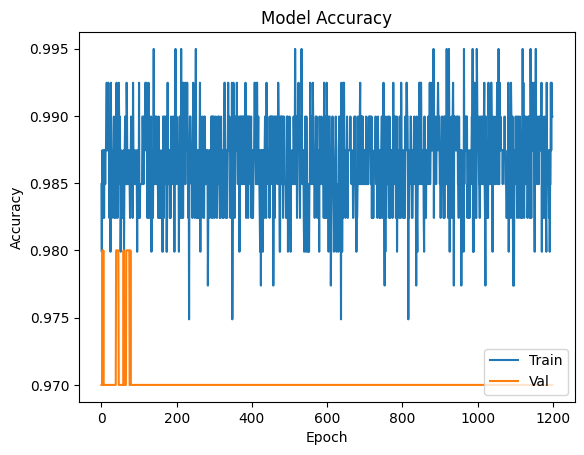

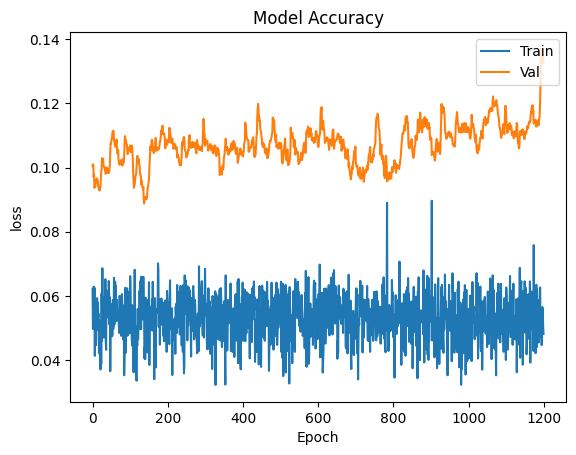

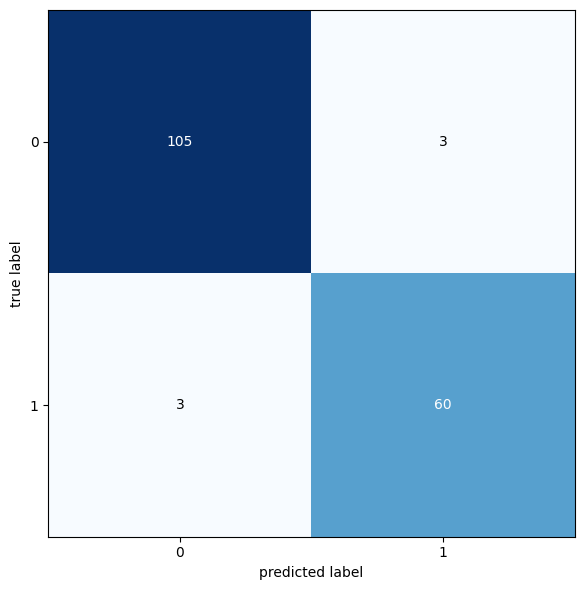

In [ ]:
#visualization of result


# plot training & validation accuracy values

plt.plot(model_history_6.history['accuracy'])
plt.plot(model_history_6.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()


# plot training & validation loss values

plt.plot(model_history_6.history['loss'])
plt.plot(model_history_6.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


matplotlib.rcParams.update(matplotlib.rcParamsDefault)
mat=confusion_matrix(y_test, fin_predict_6)
fig, ax=plot_confusion_matrix(conf_mat=mat, figsize=(6,6),show_normed=False)
plt.tight_layout()
fig.savefig('cm.png')

# (SVM + LR) + ANN

In [ ]:
new_X_train_7 = np.concatenate((lr_train, svm_train), axis = 1)
new_X_test_7 = np.concatenate((lr_test, svm_test), axis = 1)

print(X_train.shape, X_test.shape)
print(new_X_train_7.shape, new_X_test_7.shape)

(498, 30) (171, 30)
(498, 2) (171, 2)


In [ ]:
classifier_2 = Sequential() # Initialising the ANN

classifier_2.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu', input_dim = 2))
classifier_2.add(Dropout(0.1))
classifier_2.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
classifier_2.add(Dropout(0.1))
classifier_2.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
classifier_2.add(Dropout(0.1))
classifier_2.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))


## Compiling ANN
classifier_2.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

model_history_7=classifier_2.fit(new_X_train_7, y_train, batch_size = 40, epochs = 1200, validation_split=0.2)

Train on 398 samples, validate on 100 samples
Epoch 1/1200
398/398 [==============================] - 0s 434us/step - loss: 0.6923 - accuracy: 0.6382 - val_loss: 0.7002 - val_accuracy: 0.0000e+00
Epoch 2/1200
398/398 [==============================] - 0s 49us/step - loss: 0.6908 - accuracy: 0.6256 - val_loss: 0.7048 - val_accuracy: 0.0000e+00
Epoch 3/1200
398/398 [==============================] - 0s 47us/step - loss: 0.6895 - accuracy: 0.6256 - val_loss: 0.7090 - val_accuracy: 0.0000e+00
Epoch 4/1200
398/398 [==============================] - 0s 48us/step - loss: 0.6879 - accuracy: 0.6256 - val_loss: 0.7127 - val_accuracy: 0.0000e+00
Epoch 5/1200
398/398 [==============================] - 0s 53us/step - loss: 0.6861 - accuracy: 0.6256 - val_loss: 0.7147 - val_accuracy: 0.0000e+00
Epoch 6/1200
398/398 [==============================] - 0s 48us/step - loss: 0.6839 - accuracy: 0.6256 - val_loss: 0.7163 - val_accuracy: 0.0000e+00
Epoch 7/1200
398/398 [==============================] - 0s 

In [ ]:
fin_predict_7 = classifier_2.predict(new_X_test_7)
fin_predict_7 = (fin_predict_7 >= 0.5)
print(metrics.accuracy_score(y_true = y_test, y_pred=fin_predict_7))

0.9649122807017544
